Data types in X_test:
age                    float64
height                 float64
year                     int32
month                    int32
day                      int32
                        ...   
state_Virginia            bool
state_Washington          bool
state_West Virginia       bool
state_Wisconsin           bool
state_Wyoming             bool
Length: 78, dtype: object
🔍 Regression Model Performance:
MSE: 17842.08, R²: 0.14
✅ Classification Accuracy: 69.28%
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69      5181
           1       0.69      0.70      0.70      5129

    accuracy                           0.69     10310
   macro avg       0.69      0.69      0.69     10310
weighted avg       0.69      0.69      0.69     10310



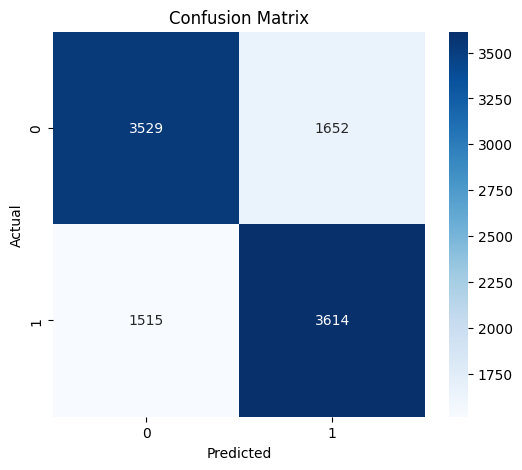

✅ Test results saved to 'test_results.csv' for visualization.


In [ ]:
"""
test_xgboost_model.py

Loads trained XGBoost models and evaluates them on test data.
Performs both regression and classification predictions.
"""

import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

# Load Test Data
CSV_FILE_PATH = "/Users/sanjojoy/Documents/MDA/data/kafka_data.csv"
df = pd.read_csv(CSV_FILE_PATH)

# Data Cleaning & Feature Engineering
df.dropna(inplace=True)

# Convert timestamp to numerical features
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df.drop(columns=["timestamp", "user_id"], inplace=True)

# Convert "interests" from string to list
def convert_interests(value):
    try:
        return ast.literal_eval(value)
    except (ValueError, SyntaxError):
        return []

df["interests"] = df["interests"].apply(convert_interests)

# Multi-label binarization for interests
mlb = MultiLabelBinarizer()
interests_encoded = pd.DataFrame(mlb.fit_transform(df["interests"]), columns=mlb.classes_)
df = df.join(interests_encoded)
df.drop(columns=["interests"], inplace=True)

# One-hot encode categorical variables
categorical_cols = ["gender", "looking_for", "children", "education_level", "occupation", "frequency_of_usage", "state"]
df = pd.get_dummies(df, columns=categorical_cols)

# Normalize numerical features
scaler = StandardScaler()
df[["age", "height"]] = scaler.fit_transform(df[["age", "height"]])

# Define test data targets and features
df["engagement_label"] = df["swiping_history"].apply(lambda x: 1 if x >= 250 else 0)
X_test = df.drop(columns=["swiping_history", "engagement_label"])
y_reg_test = df["swiping_history"]
y_clf_test = df["engagement_label"]

# Debug: verify data types
print("Data types in X_test:")
print(X_test.dtypes)



🔍 Regression Model Performance:
MSE: 17842.08, R²: 0.14
✅ Classification Accuracy: 69.28%
📊 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.68      0.69      5181
           1       0.69      0.70      0.70      5129

    accuracy                           0.69     10310
   macro avg       0.69      0.69      0.69     10310
weighted avg       0.69      0.69      0.69     10310



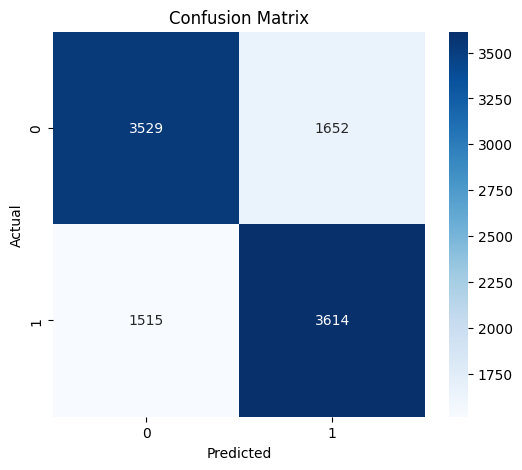

✅ Test results saved to 'test_results.csv' for visualization.


In [5]:
 #Load Trained Models
with open("/Users/sanjojoy/Documents/MDA/models/xgb_regressor.pkl", "rb") as f:
    xgb_reg = pickle.load(f)

with open("xgb_classifier.pkl", "rb") as f:
    xgb_clf = pickle.load(f)

# Regression Predictions
y_reg_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_reg_test, y_reg_pred)
r2 = xgb_reg.score(X_test, y_reg_test)
print(f"🔍 Regression Model Performance:\nMSE: {mse:.2f}, R²: {r2:.2f}")

# Classification Predictions
y_clf_pred = xgb_clf.predict(X_test)
accuracy = accuracy_score(y_clf_test, y_clf_pred)
print(f"✅ Classification Accuracy: {accuracy:.2%}")
print("📊 Classification Report:\n", classification_report(y_clf_test, y_clf_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_clf_test, y_clf_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Create DataFrame with Predictions for Dashboard
test_results_df = df.copy()
test_results_df["predicted_swipes"] = y_reg_pred
test_results_df["predicted_engagement"] = y_clf_pred

# Save to CSV
test_results_df.to_csv("test_results.csv", index=False)
print("✅ Test results saved to 'test_results.csv' for visualization.")